In [1]:
import urllib.parse
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd


Wikispedia is an online activity where players navigate from one Wikipedia article to another using only the internal links within each page. The objective is to reach a specific target article from a given starting point in the fewest number of clicks or the shortest time possible. This data is the actual travel path the human takes. 


In [2]:
#First things first, lets read in our data

file_path = 'links.tsv'
df = pd.read_csv(file_path, sep='\t')
df.head()

,encoded_root,raw_topic
0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Bede
1,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Columba
2,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,D%C3%A1l_Riata
3,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Great_Britain
4,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Ireland


In [3]:
#There is an encoding on our links, so let's first decode it:
df['root'] = df['encoded_root'].apply(lambda x: urllib.parse.unquote(x))
df.head()

,encoded_root,raw_topic,root
0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Bede,Áedán_mac_Gabráin
1,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Columba,Áedán_mac_Gabráin
2,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,D%C3%A1l_Riata,Áedán_mac_Gabráin
3,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Great_Britain,Áedán_mac_Gabráin
4,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Ireland,Áedán_mac_Gabráin


In [4]:
#There is still some irregularity in the raw_topic column, IE 'D%C3%A1l_Riata'. Looking at the page, it appears as though its supposed to be  Dál Riata.
#This indicates that the topic, encoded root, and decoded have diffent encoding schemas for how they handle characters
#Lets try and solve this issue
def character_correct(encoded_string):
    decoded_string = urllib.parse.unquote(encoded_string)
    final_string = decoded_string.replace('_', ' ')
    return final_string

df['root'] = df['root'].apply(character_correct)
df['topic'] = df['raw_topic'].apply(character_correct)
df

,encoded_root,raw_topic,root,topic
0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Bede,Áedán mac Gabráin,Bede
1,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Columba,Áedán mac Gabráin,Columba
2,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,D%C3%A1l_Riata,Áedán mac Gabráin,Dál Riata
3,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Great_Britain,Áedán mac Gabráin,Great Britain
4,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,Ireland,Áedán mac Gabráin,Ireland
...,...,...,...,...
119877,Zulu,South_Africa,Zulu,South Africa
119878,Zulu,Swaziland,Zulu,Swaziland
119879,Zulu,United_Kingdom,Zulu,United Kingdom
119880,Zulu,Zambia,Zulu,Zambia


In [5]:
#Now that is looking a lot better. From here, we need to focus on creating the linkages between nodes.
#We have a series of items that are essentially lists linking one item to another

graph = nx.DiGraph()
for index, row in df.iterrows():
    graph.add_edge(row['root'], row['topic'])
print(nx.info(graph))


Name: 
Type: DiGraph
Number of nodes: 4592
Number of edges: 119882
Average in degree:  26.1067
Average out degree:  26.1067


In [6]:
#I really just want to visualize this, but the node size does not effectively enable visualisation. 

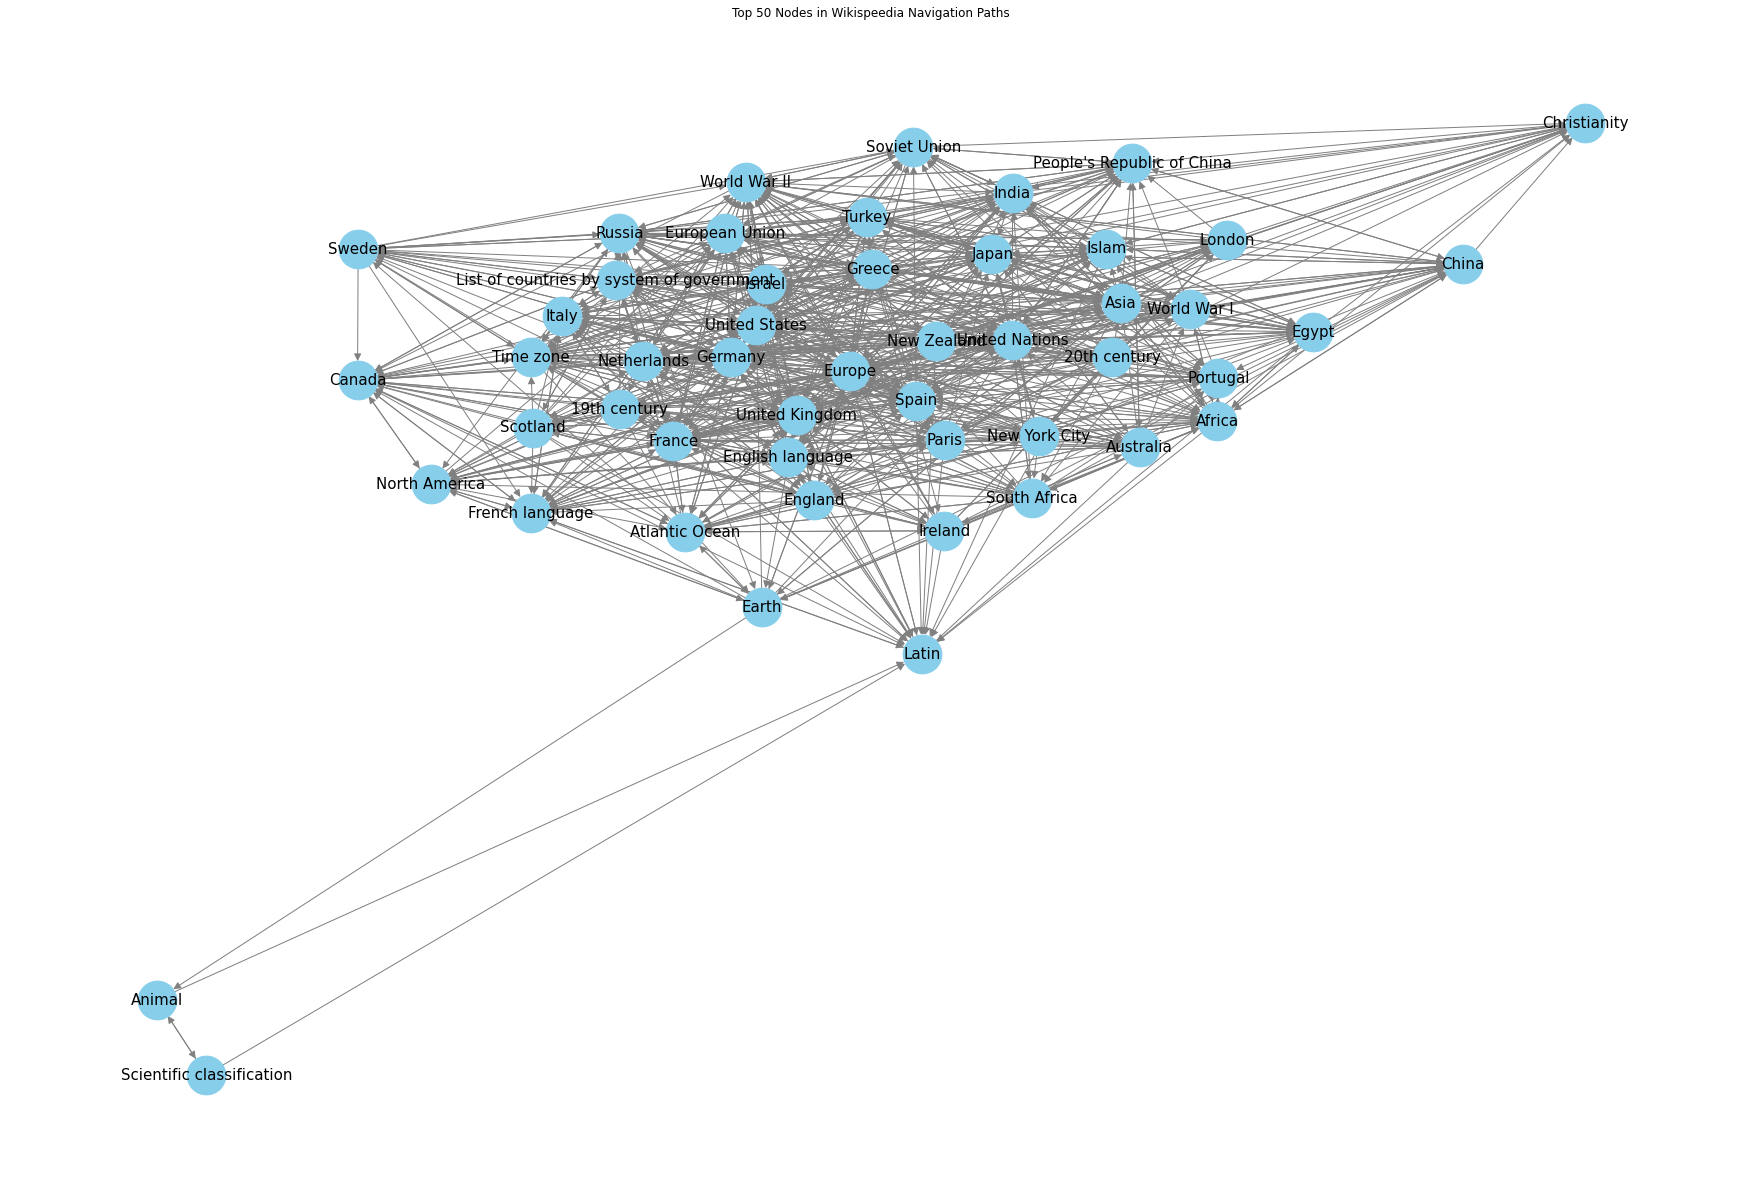

In [7]:
#Graphing all the nodes is not possible. 
top_50_nodes = sorted(graph.degree, key=lambda x: x[1], reverse=True)[:50]
top_50_nodes = [node for node, degree in top_50_nodes]

#Create a subgraph
subgraph = graph.subgraph(top_50_nodes) #I'm trimming down the data so my laptop can handle this
plt.figure(figsize=(24, 16))
pos = nx.spring_layout(subgraph, k=0.1)  
nx.draw(subgraph, pos, node_size=1500, node_color='skyblue', edge_color='gray', with_labels=True, font_size=15, arrowsize=15)
plt.title("Top 50 Nodes in Wikispeedia Navigation Paths")
plt.show()


In [8]:
#Lets look at the diameter. Lets focus in on just the top 50 as trying to compute the full dataset requries too much compute. 

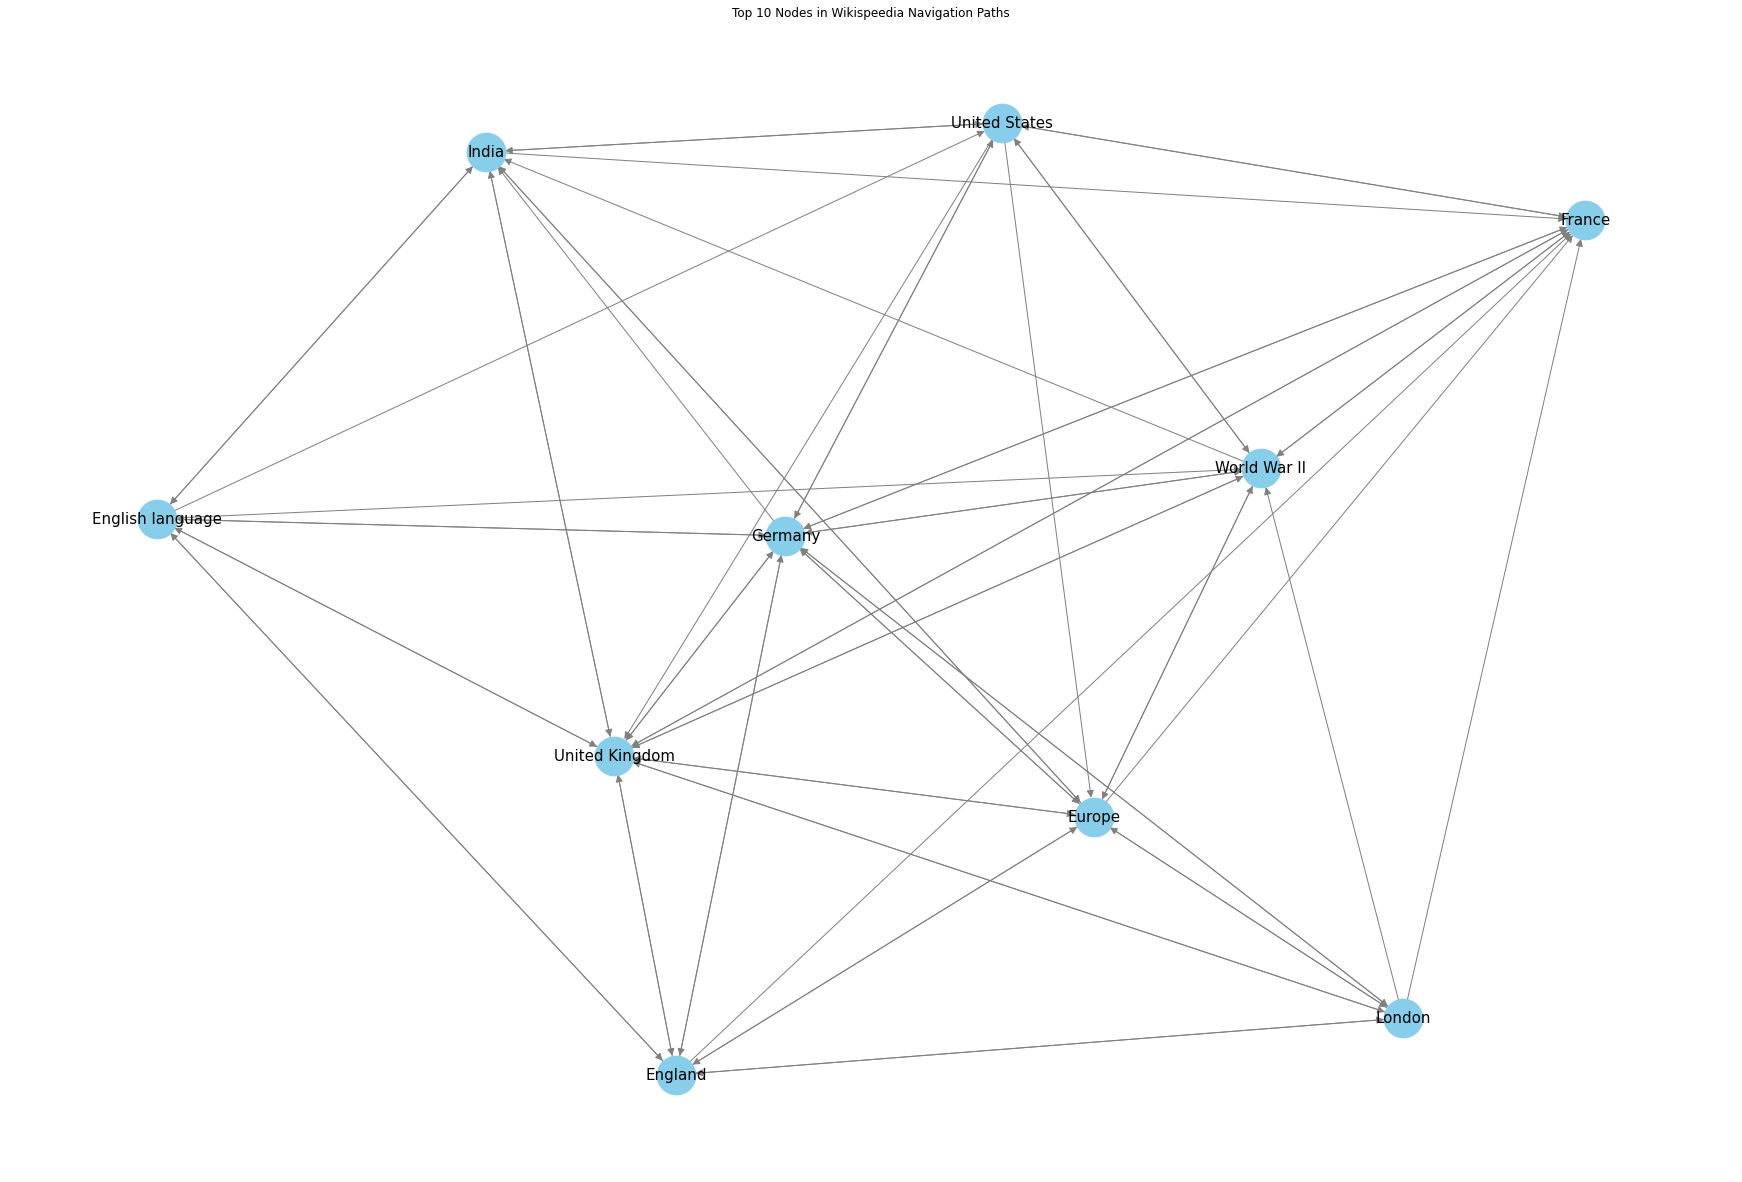

In [18]:
#As per geeks for geeks:
#Strongly Connected: A graph is said to be strongly connected if every pair of vertices(u, v) in the graph contains a path between each other. In an unweighted directed graph G, every pair of vertices u and v should have a path in each direction between them i.e., bidirectional path. The elements of the path matrix of such a graph will contain all 1’s.
#Unilaterally Connected: A graph is said to be unilaterally connected if it contains a directed path from u to v OR a directed path from v to u for every pair of vertices u, v. Hence, at least for any pair of vertices, one vertex should be reachable form the other. Such a path matrix would rather have upper triangle elements containing 1’s OR lower triangle elements containing 1’s.
#Weakly Connected: A directed graph is weakly connected if there is a path between every two vertices in the underlying undirected graph (i.e, the graph formed when the direction of the edges are removed).
#Were goinge to create a cut of the top 10, so that we can functionally work with this data. 

top_10_nodes = sorted(graph.degree, key=lambda x: x[1], reverse=True)[:10] #Lets get the top 10
top_10_nodes = [node for node, degree in top_10_nodes]

#Create a subgraph with the top 10 nodes
subgraph = graph.subgraph(top_10_nodes) #filter down to a subgraph
plt.figure(figsize=(24, 16))
pos = nx.spring_layout(subgraph, k=0.1) #Set Layout for spread
nx.draw(subgraph, pos, node_size=1500, node_color='skyblue', edge_color='gray', with_labels=True, font_size=15, arrowsize=15)
plt.title("Top 10 Nodes in Wikispeedia Navigation Paths")
plt.show()


Diameter of the largest connected component: 2
Diameter path: ['India', 'English language', 'World War II']


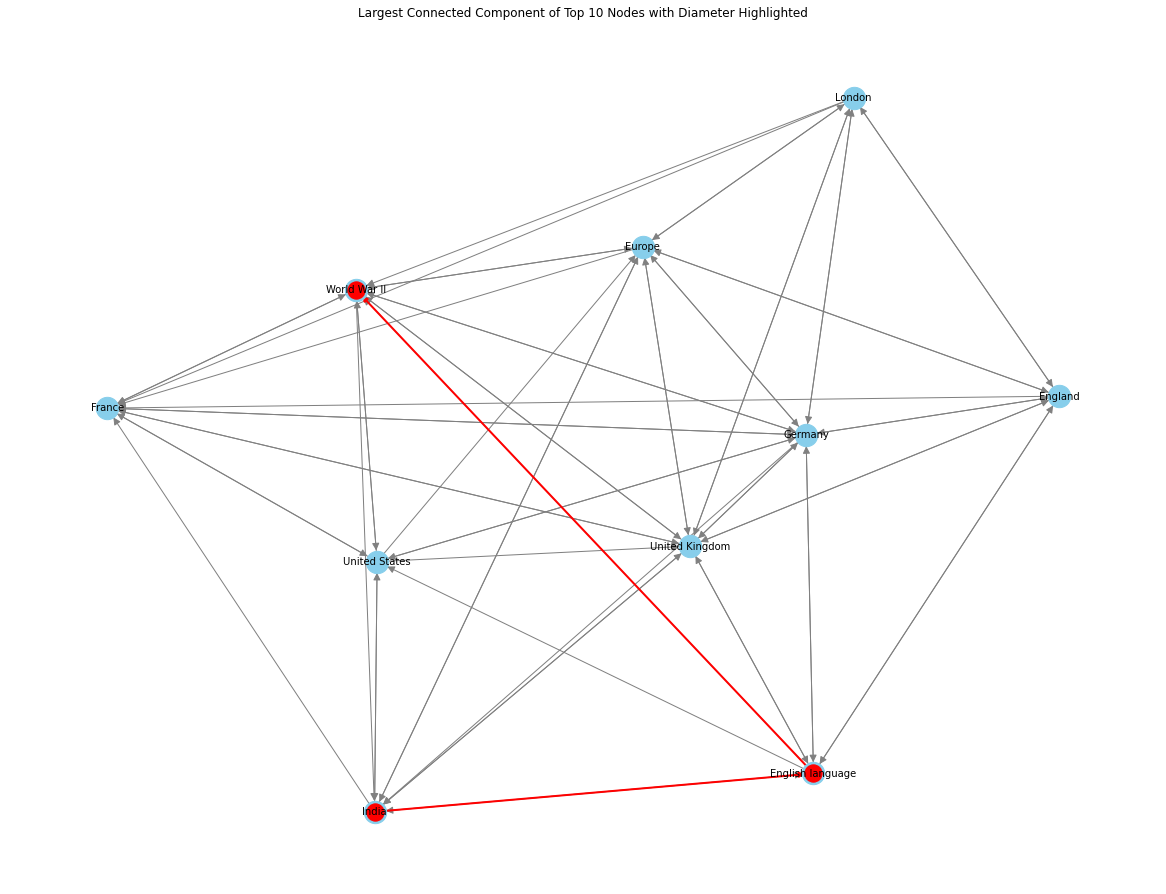

In [17]:
largest_cc = max(nx.connected_components(subgraph.to_undirected()), key=len)  #Basics for this line are here, converted my directed subgraph to an undirected one to match required parameters: https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.components.connected_components.html
largest_cc_subgraph = subgraph.subgraph(largest_cc) #Create subgraph of the largest connected components

#Check if the largest connected component subgraph is connected
if nx.is_connected(largest_cc_subgraph.to_undirected()): #Check to see if every node is connected. If they are not, it will not have a diameter.
    #The Diameter is essentially the longest shortest path.
    diameter = nx.diameter(largest_cc_subgraph) #Lets get the diameter
    print("Diameter of the largest connected component:", diameter)

    #Lets try and get the path we need to acheive the diameter:
    diameter_path = None
    for node in largest_cc_subgraph.nodes: #Iterate through all the nodes
        for target in largest_cc_subgraph.nodes:
            if node != target:
                length = nx.shortest_path_length(largest_cc_subgraph, source=node, target=target)
                if length == diameter:
                    diameter_path = nx.shortest_path(largest_cc_subgraph, source=node, target=target)
                    break
        if diameter_path:
            break

    print("Diameter path:", diameter_path)

    #Draw the largest connected component subgraph
    plt.figure(figsize=(16, 12))
    pos = nx.spring_layout(largest_cc_subgraph, k=0.1)  # Positions for all nodes
    nx.draw(largest_cc_subgraph, pos, node_size=500, node_color='skyblue', edge_color='gray', with_labels=True, font_size=10, arrowsize=15)

    #Highlight the diameter path
    if diameter_path:
        path_edges = list(zip(diameter_path, diameter_path[1:]))
        nx.draw_networkx_nodes(largest_cc_subgraph, pos, nodelist=diameter_path, node_color='red')
        nx.draw_networkx_edges(largest_cc_subgraph, pos, edgelist=path_edges, edge_color='red', width=2)

    plt.title("Largest Connected Component of Top 10 Nodes with Diameter Highlighted")
    plt.show()
else:
    print("The largest connected component subgraph is not connected. Cannot compute the diameter.")

In [ ]:
#I want to find the center
#Per wikipedia (https://en.wikipedia.org/wiki/Graph_center#cite_note-2) and cross referenced with (https://web.archive.org/web/20100801092700/http://www.cs.njit.edu/mchugh/psswrd/web-course-materials/graph-theory/alg-graph-theory-text-html/chap-1-text-v3.html)
#The center "of a graph is the set of all vertices of minimum eccentricity,[2] that is, the set of all vertices u where the greatest distance d(u,v) to other vertices v is minimal."

In [ ]:
#Emperically, the spring_layout which treats nodes like repelling object would indicate that germany, the UK or europe could all be potential centers
#Lets test it out:

In [11]:
list(nx.center(subgraph))

['Germany']

In [ ]:
#As we predicted, its one of the 3! Let's Try calculating this without using the center function. 

Center nodes: ['Germany']


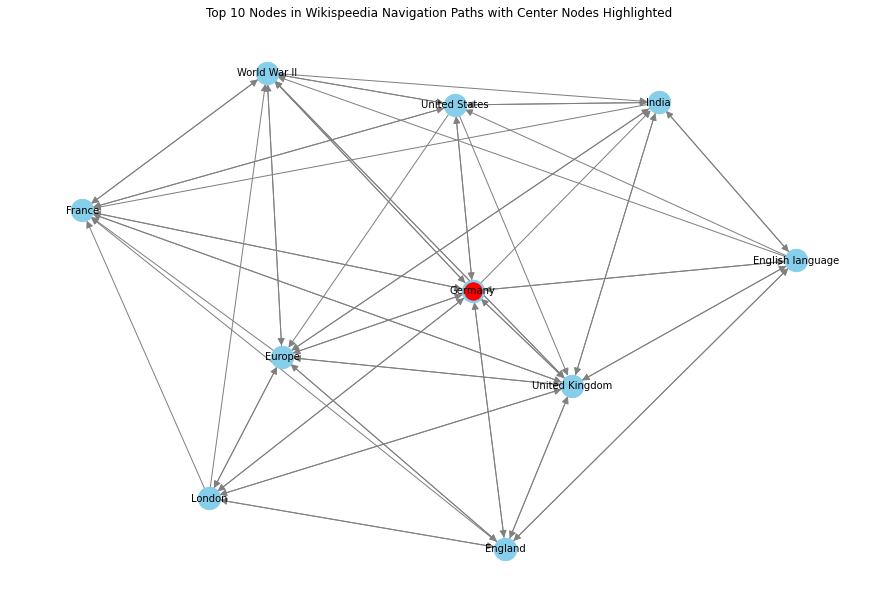

In [12]:
eccentricity = nx.eccentricity(largest_cc_subgraph)  #By Definition, minimum eccentricity implies center 
#eccentricity is defined as the maximum distance of one vertex from other vertex
#Find the center nodes (nodes with minimum eccentricity)
min_eccentricity = min(eccentricity.values())
center_nodes = [node for node, ecc in eccentricity.items() if ecc == min_eccentricity] #Get all nodes with the lowest eccentricity
print("Center nodes:", center_nodes) 

#Draw
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(largest_cc_subgraph, k=0.1)  # Positions for all nodes
nx.draw(largest_cc_subgraph, pos, node_size=500, node_color='skyblue', edge_color='gray', with_labels=True, font_size=10, arrowsize=15)

#Highlight the center nodes
nx.draw_networkx_nodes(largest_cc_subgraph, pos, nodelist=center_nodes, node_color='red')

plt.title("Top 10 Nodes in Wikispeedia Navigation Paths with Center Nodes Highlighted")
plt.show()